## 准备数据

In [34]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers, optimizers
from keras.datasets import mnist
from torch import optim

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

def mnist_dataset():
    (x, y), (x_test, y_test) = mnist.load_data()
    #normalize
    x = x/255.0
    x_test = x_test/255.0
    
    return (x, y), (x_test, y_test)

In [35]:
print(list(zip([1, 2, 3, 4], ['a', 'b', 'c', 'd'])))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]


## 构建全连接层

In [36]:
class FullConnectionLayer:
    def __init__(self):
        self.mem = {}
    def forward(self, X, W):
        """
        :param X: shape(m,d),前向传播输入矩阵
        :param W: shape(d,d'),前向传播权重矩阵
        :return: 前向传播输出矩阵
        """
        self.mem['X'] = X
        self.mem['W'] = W
        H = np.matmul(X, W)
        return H
    def backward(self, grad_H):
        """
        :param grad_H: shape(m,d'),Loss关于 H 的梯度
        :return: grad_X: shape(m,d),Loss关于 X 的梯度
                 grad_W: shape(d,d'),Loss关于 W 的梯度
        """
        X = self.mem['X']
        W = self.mem['W']
        grad_X = np.matmul(grad_H, W.T)
        grad_W = np.matmul(X.T, grad_H)
        return grad_X, grad_W
            

## 实现relu激活函数

In [37]:
class Relu:
    def __init__(self):
        self.mem = {}
        
    def forward(self, x):
        self.mem['x']=x
        return np.where(x > 0, x, np.zeros_like(x))
    
    def backward(self, grad_y):
        grad_x = np.where(self.mem['x']>0, grad_y, np.zeros_like(grad_y))
        return grad_x
    
    
class CrossEntropy():
    def __init__(self):
        self.mem = {}
        self.epsilon = 1e-12  # 防止求导后分母为 0

    def forward(self, p, y):
        self.mem['p'] = p
        log_p = np.log(p + self.epsilon)
        return np.mean(np.sum(-y * log_p, axis=1))

    def backward(self, y):
        p = self.mem['p']
        return -y * (1 / (p + self.epsilon))

## 建立模型

In [38]:
class myModel:
    def __init__(self):
        self.W1 = np.random.normal(size=[28*28+1, 100])
        self.W2 = np.random.normal(size=[100, 10])
        
        self.mul_h1 = FullConnectionLayer()
        self.mul_h2 = FullConnectionLayer()
        self.relu1 = Relu()
        self.relu2 = Relu()
        self.cross_en = CrossEntropy()
        
    def forward(self, x, label):
        x = x.reshape(-1, 28*28)
        bias = np.ones(shape=[x.shape[0], 1])
        x = np.concatenate([x, bias], axis=1)
        self.h1 = self.mul_h1.forward(x, self.W1)
        self.h1_relu = self.relu1.forward(self.h1)
        self.h2 = self.mul_h2.forward(self.h1_relu, self.W2)
        self.h2_relu = self.relu2.forward(self.h2)
        self.loss = self.cross_en.forward(self.h2_relu, label)
        
    def backward(self, label):
        self.loss_grad = self.cross_en.backward(label)
        self.h2_relu_grad = self.relu2.backward(self.loss_grad)
        self.h2_grad, self.W2_grad = self.mul_h2.backward(self.h2_relu_grad)
        self.h1_relu_grad = self.sigmoid.backward(self.h2_grad)
        self.h1_grad, self.W1_grad = self.mul_h1.backward(self.h1_relu_grad)
    
model = myModel()

optimizer = optim.Adam


## 计算 loss

In [39]:
def compute_accuracy(prob, labels):
    predictions = np.argmax(prob, axis=1)
    truth = np.argmax(labels, axis=1)
    return np.mean(predictions==truth)

def train_one_step(model, x, y):
    model.forward(x, y)
    model.backward(y)
    model.W1 -= 1e-5* model.W1_grad
    model.W2 -= 1e-5* model.W2_grad
    loss = model.loss
    accuracy = compute_accuracy(model.h2_soft, y)
    return loss, accuracy

def test(model, x, y):
    model.forward(x, y)
    loss = model.loss
    accuracy = compute_accuracy(model.h2_soft, y)
    return loss, accuracy


## 实际训练

In [40]:
train_data, test_data = mnist_dataset()
train_label = np.zeros(shape=[train_data[0].shape[0], 10])
test_label = np.zeros(shape=[test_data[0].shape[0], 10])
train_label[np.arange(train_data[0].shape[0]), np.array(train_data[1])] = 1.
test_label[np.arange(test_data[0].shape[0]), np.array(test_data[1])] = 1.

for epoch in range(50):
    loss, accuracy = train_one_step(model, train_data[0], train_label)
    print('epoch', epoch, ': loss', loss, '; accuracy', accuracy)
loss, accuracy = test(model, test_data[0], test_label)

print('test loss', loss, '; accuracy', accuracy)

AttributeError: 'myModel' object has no attribute 'sigmoid'

## 多层神经网络模型搭建
我在原来的两层神经网络的基础上尝试搭建多层神经网络，结果发现预测效果不增反降，事实证明网络层数太深并非一件好事，可能造成网络的退化

In [ ]:
def compute_accuracy2(prob, labels):
    predictions = np.argmax(prob, axis=1)
    truth = np.argmax(labels, axis=1)
    return np.mean(predictions==truth)

def train_one_step2(model, x, y):
    model.forward(x, y)
    model.backward(y)
    model.W1 -= model.learning_rate * model.W1_grad
    model.W2 -= model.learning_rate * model.W2_grad
    model.W3 -= model.learning_rate * model.W3_grad
    model.W4 -= model.learning_rate * model.W4_grad
    loss = model.loss
    accuracy = compute_accuracy2(model.h4_relu, y)
    return loss, accuracy

def test2(model, x, y):
    model.forward(x, y)
    loss = model.loss
    accuracy = compute_accuracy2(model.h4_relu, y)
    return loss, accuracy

class myModel2:
    def __init__(self):
        self.W1 = np.random.normal(size=[28*28+1, 100])
        self.W2 = np.random.normal(size=[100, 100])
        self.W3 = np.random.normal(size=[100, 100])
        self.W4 = np.random.normal(size=[100, 10])
        
        self.mul_h1 = FullConnectionLayer()
        self.mul_h2 = FullConnectionLayer()
        self.mul_h3 = FullConnectionLayer()
        self.mul_h4 = FullConnectionLayer()
        self.relu1 = Relu()
        self.relu2 = Relu()
        self.relu3 = Relu()
        self.relu4 = Relu()
        self.cross_en = CrossEntropy()
        self.learning_rate = 1e-5
        
    def forward(self, x, label):
        x = x.reshape(-1, 28*28)
        bias = np.ones(shape=[x.shape[0], 1])
        x = np.concatenate([x, bias], axis=1)
        self.h1 = self.mul_h1.forward(x, self.W1)
        self.h1_relu = self.relu1.forward(self.h1)
        self.h2 = self.mul_h2.forward(self.h1_relu, self.W2)
        self.h2_relu = self.relu2.forward(self.h2)
        self.h3 = self.mul_h3.forward(self.h2_relu, self.W3)
        self.h3_relu = self.relu3.forward(self.h3)
        self.h4 = self.mul_h4.forward(self.h3_relu, self.W4)
        self.h4_relu = self.relu4.forward(self.h4)
        self.loss = self.cross_en.forward(self.h4_relu, label)
        
    def backward(self, label):
        self.loss_grad = self.cross_en.backward(label)
        
        self.h4_relu_grad = self.relu4.backward(self.loss_grad)
        self.h4_grad, self.W4_grad = self.mul_h4.backward(self.h4_relu_grad)
        self.h3_relu_grad = self.relu3.backward(self.h4_grad)
        self.h3_grad, self.W3_grad = self.mul_h3.backward(self.h3_relu_grad)
        self.h2_relu_grad = self.relu2.backward(self.h3_grad)
        self.h2_grad, self.W2_grad = self.mul_h2.backward(self.h2_relu_grad)
        self.h1_relu_grad = self.relu1.backward(self.h2_grad)
        self.h1_grad, self.W1_grad = self.mul_h1.backward(self.h1_relu_grad)
        
    
model2 = myModel2()

# optimizer = optimizers.Adam()
optimizer2 = optim.Adam

for epoch in range(50):
    loss, accuracy = train_one_step2(model2, train_data[0], train_label)
    print('epoch', epoch, ': loss', loss, '; accuracy', accuracy)
loss, accuracy = test2(model2, test_data[0], test_label)

print('test loss', loss, '; accuracy', accuracy)

## Part2. 拟合简单函数

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [44]:
class myModel3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(myModel3, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.learning_rate = 1e-2
        
    def forward(self, x):
        h1 = self.layer1(x)
        h1_relu = self.relu(h1)
        h2 = self.layer2(h1_relu)
        return h2        

In [45]:
def train(fun, model, epochs=5000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate)
    
    x_train = torch.linspace(-10, 10, 100).view(-1,1)
    y_train = fun(x_train)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    return x_train, y_train, model

In [46]:
def fun1(x):
    return np.sin(x)

def fun2(x):
    return np.sin(x) * np.sin(x) + x**3 * np.cos(x) + 4*x +2

def fun3(x):
    return x**4 - x**3 + x**2 - x + 1

In [47]:
funs = [fun1, fun2, fun3]
results = []

for fun in funs:
    model = myModel3(1, 100, 1)
    x_train, y_train, trained_network = train(fun, model)
    y_pred = trained_network(x_train)
    results.append((x_train, y_train, y_pred))

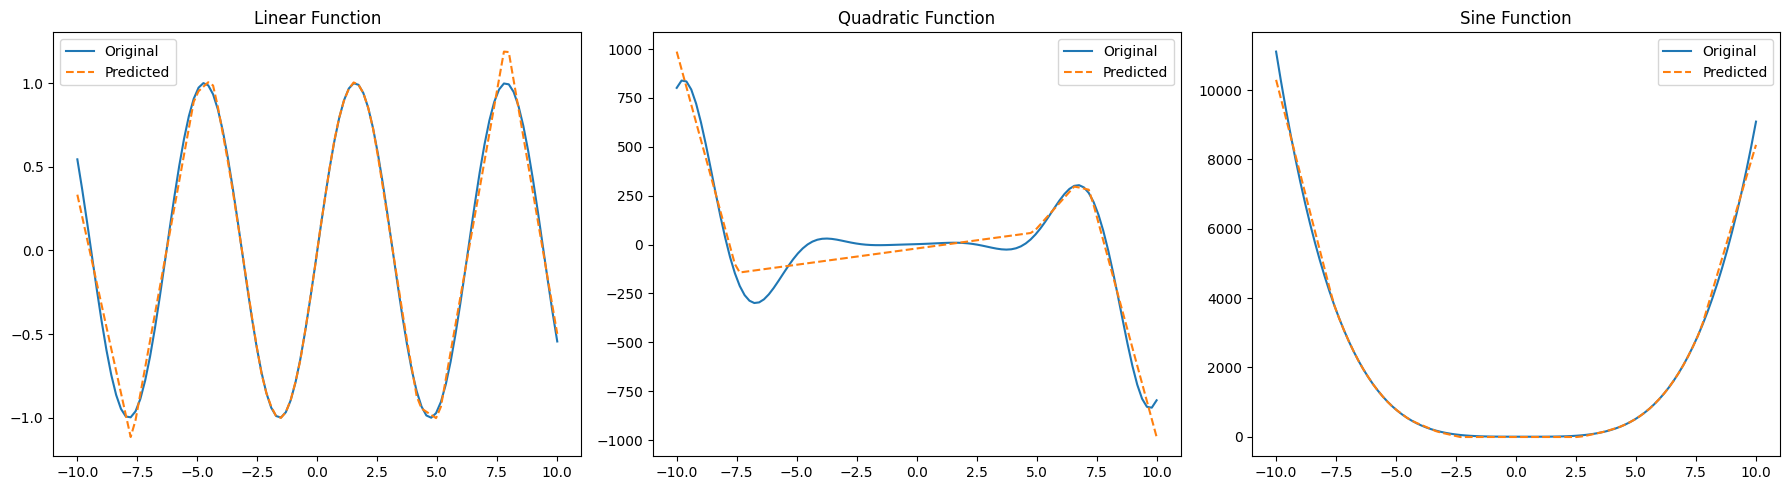

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Linear Function', 'Quadratic Function', 'Sine Function']

for i, (x_train, y_train, y_pred) in enumerate(results):
    axs[i].plot(x_train.data.numpy(), y_train.data.numpy(), label='Original')
    axs[i].plot(x_train.data.numpy(), y_pred.data.numpy(),
                label='Predicted', linestyle='--')
    axs[i].set_title(titles[i])
    axs[i].legend()

plt.tight_layout()
plt.show()